# 📚 MLP Neural Network for Predicting Calls Count

This notebook trains a **Multi-Layer Perceptron (MLP)** model to predict the number of calls per day.
We use features engineered from year, month, weekday, topic, holiday, rain, and momentum indicators.
The workflow:
- Load and prepare the dataset
- Build the MLP model
- Train the model
- Evaluate performance
- Plot training history


In [1]:
# 📚 Improved LSTM Model with Standard Deviation Checks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime


# 📂 Load and Prepare the Dataset
We load the cleaned dataset ready for modeling from the `ready_for_models_final.csv` file.
We will also engineer additional momentum features later on.


In [2]:
# =============================
# Load and prepare the data
# =============================

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/מדעי המחשב/שנה ג/סמסטר ב/האקתון דאטה/DATA/normalized_ready_for_models (1).csv')
print(f"✅ Data loaded successfully! Shape: {data.shape}")

# =============================

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully! Shape: (98095, 205)


In [3]:
# =============================
# Aggregate and engineer features
# =============================

group_keys = []
group_keys += [col for col in data.columns if col.startswith('שנה_')]
group_keys += [col for col in data.columns if col.startswith('חודש_')]
group_keys += [col for col in data.columns if col.startswith('יום_')]
group_keys += [col for col in data.columns if col.startswith('נושא_')]
group_keys += ['חג', 'Rain']

agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
agg_daily_topic = agg_daily_topic.sort_values(by=group_keys)
agg_daily_topic['calls_last_3'] = agg_daily_topic['calls_count'].rolling(window=3, min_periods=1).mean().shift(1)
agg_daily_topic['calls_last_7'] = agg_daily_topic['calls_count'].rolling(window=7, min_periods=1).mean().shift(1)
agg_daily_topic[['calls_last_3', 'calls_last_7']] = agg_daily_topic[['calls_last_3', 'calls_last_7']].fillna(0)

print("✅ Aggregated and added momentum features.")

✅ Aggregated and added momentum features.


<ipython-input-3-22f55850cf92>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
<ipython-input-3-22f55850cf92>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_daily_topic = data.groupby(group_keys).size().reset_index(name='calls_count')
<ipython-input-3-22f55850cf92>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

In [4]:
# =============================
# Prepare Features and Target
# =============================

X = agg_daily_topic.drop(columns=['calls_count'])
y = agg_daily_topic['calls_count']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"✅ Features shape (for LSTM): {X_train.shape}")
print(f"✅ Target shape: {y_train.shape}")

✅ Features shape (for LSTM): (17474, 1, 114)
✅ Target shape: (17474,)


In [5]:
# =============================
# Build Improved LSTM Model
# =============================

model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("✅ Improved LSTM model compiled.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Improved LSTM model compiled.


In [6]:
# =============================
# Train the Model
# =============================

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stop], verbose=1)


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 53.1854 - mae: 4.1476 - val_loss: 29.9711 - val_mae: 3.2515
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.1981 - mae: 2.8638 - val_loss: 16.7585 - val_mae: 2.1832
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 16.2051 - mae: 2.2970 - val_loss: 15.2333 - val_mae: 2.0693
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13.4419 - mae: 2.0779 - val_loss: 14.7179 - val_mae: 1.9374
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 12.9370 - mae: 1.9479 - val_loss: 13.9276 - val_mae: 1.8501
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.6745 - mae: 1.9089 - val_loss: 13.4890 - val_mae: 1.8624
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.2899 - mae: 1.8782 - val_loss: 13.2223 - val_mae: 1.8490
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 12.0913 - mae: 1.8714 - val_loss: 13.1396 - val_mae: 1.8394
Epoch 9/100
274/274 ━━━━━━━━━━━━

In [7]:
# =============================
# Evaluate the Model
# =============================

y_pred_lstm = model.predict(X_test).flatten()

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print("=== LSTM Improved Results ===")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R2 Score: {r2_lstm:.2f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== LSTM Improved Results ===
MAE: 1.64
RMSE: 3.14
R2 Score: 0.75


In [8]:
# =============================
# Standard Deviation Checks
# =============================

train_errors = y_train.values - model.predict(X_train).flatten()
test_errors = y_test.values - y_pred_lstm

print("=== Standard Deviation Check ===")
print(f"Train Error Std: {np.std(train_errors):.2f}")
print(f"Test Error Std: {np.std(test_errors):.2f}")
print(f"Train y Std: {np.std(y_train):.2f}")
print(f"Test y Std: {np.std(y_test):.2f}")

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
=== Standard Deviation Check ===
Train Error Std: 2.55
Test Error Std: 3.14
Train y Std: 6.17
Test y Std: 6.33


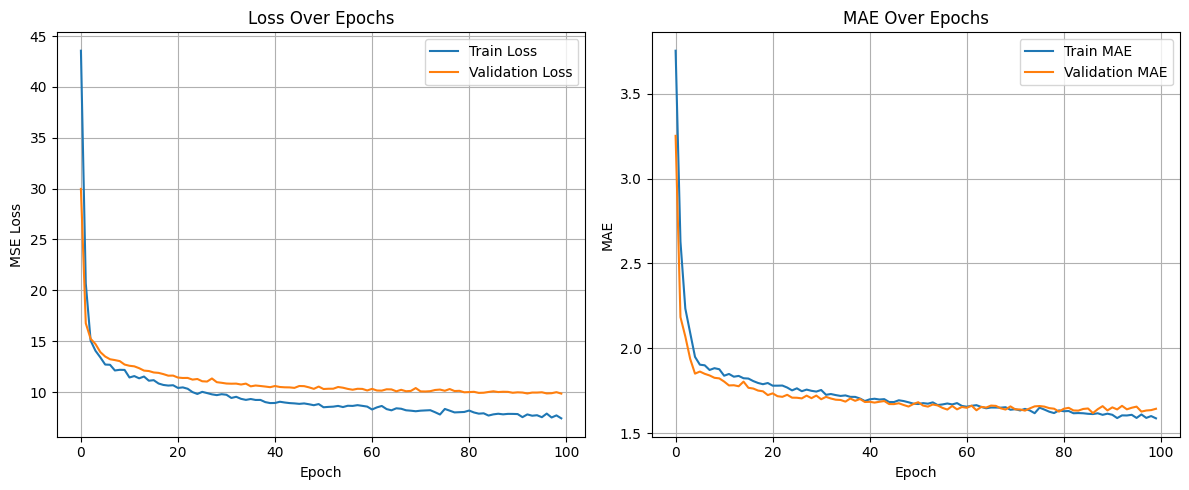

In [9]:
# =============================
# Plot Training History
# =============================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:

scaler_cols   = list(scaler.feature_names_in_)       # 138
model_feats   = model.input_shape[-1]                # 114
heb_day_num   = {'שני':0,'שלישי':1,'רביעי':2,'חמישי':3,'שישי':4,'שבת':5,'ראשון':6}

In [11]:
def blank(n):
    return pd.DataFrame(0, index=range(n), columns=scaler_cols, dtype='float32')

In [12]:
# ----- 1. Dates -----
dates = pd.date_range(datetime.now(), periods=14, freq='D')
base  = pd.DataFrame({'date':dates})
base['dow']   = base['date'].dt.dayofweek
base['month'] = base['date'].dt.month
base['year']  = base['date'].dt.year
base['hour']  = 10

In [13]:
# ----- 2. departments -----
dept_cols = [c for c in scaler_cols if c.startswith('נושא_')]
depts     = [c.replace('נושא_','') for c in dept_cols]
future    = pd.concat([base.assign(נושא=d) for d in depts], ignore_index=True)


In [14]:
# ----- 3. build one hot encoded -----
F = blank(len(future))

for c in [x for x in scaler_cols if x.startswith('שנה_')]:
    F.loc[ future['year']==int(c.split('_')[1]), c] = 1
for c in [x for x in scaler_cols if x.startswith('חודש_')]:
    F.loc[ future['month']==int(c.split('_')[1]), c] = 1
for c in [x for x in scaler_cols if x.startswith('יום_')]:
    F.loc[ future['dow']==heb_day_num[c.split('_')[1]] , c] = 1
for c in [x for x in scaler_cols if x.startswith('שעה_')]:
    F.loc[ future['hour']==int(c.split('_')[1]) , c] = 1
for c in dept_cols:
    F.loc[ future['נושא']==c.replace('נושא_','') , c] = 1
# Rain / חג / calls_last_3/7 נשארים 0 כפי שב-blank()

In [15]:
# ----- 4. scaling -----
X = scaler.transform(F)                    # (N, 138)

# ----- 5. fit to model -----
if X.shape[1] > model_feats:               # חתוך ל-114
    X = X[:, :model_feats]
elif X.shape[1] < model_feats:             # פדינג אם צריך
    X = np.pad(X, ((0,0),(0, model_feats - X.shape[1])), 'constant')

X = np.expand_dims(X, 1)                   # (N,1,114)


In [16]:
# ----- 6. חיזוי -----
pred = model.predict(X, verbose=0).flatten()

# ----- 7. תוצאה -----
future['calls_pred'] = pred
future['date']       = future['date'].dt.date
out = future[['date', 'נושא', 'calls_pred']]

# שמירה והצגה קצרה
out.to_csv('/content/future_load_predictions.csv', index=False, encoding='utf-8-sig')
print(out.head())          # מדפיס את חמש השורות הראשונות
print("✅  Saved to /content/future_load_predictions.csv | rows:", len(out))


         date                 נושא  calls_pred
0  2025-04-29  אי החזרת פחים למקום    3.274451
1  2025-04-30  אי החזרת פחים למקום    4.558764
2  2025-05-01  אי החזרת פחים למקום    2.482584
3  2025-05-02  אי החזרת פחים למקום    1.995117
4  2025-05-03  אי החזרת פחים למקום    1.785152
✅  Saved to /content/future_load_predictions.csv | rows: 1176



### 🔮 LSTM Forecasting Model

This notebook trains an LSTM model to forecast the number of daily service calls per topic.  
It uses one-hot encoded time features, weather, and momentum signals (last 3/7 days).  
The model predicts 14 future days and saves the results to `future_load_predictions.csv`.


In [21]:
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
from alibi.explainers import Counterfactual

# ========== תנאים מוקדמים ==========
if 'X_test' not in globals():
    raise ValueError("⛔ X_test לא נמצא בסביבה. צריך את X_test על פיו תריץ XAI.")

# לוקחים למשל 100 דגימות הסבר
X_sample = X_test[:,0,:]   # יוציא מה-axis הראשון (N,features) מהמבנה (N,1,features)

# פונקציית חיזוי עבור המודל המאומן
predict_fn = lambda x: model.predict(x.reshape((-1,1,X_sample.shape[1]))).flatten()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<ipython-input-27-3d2cd453bbb2>:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


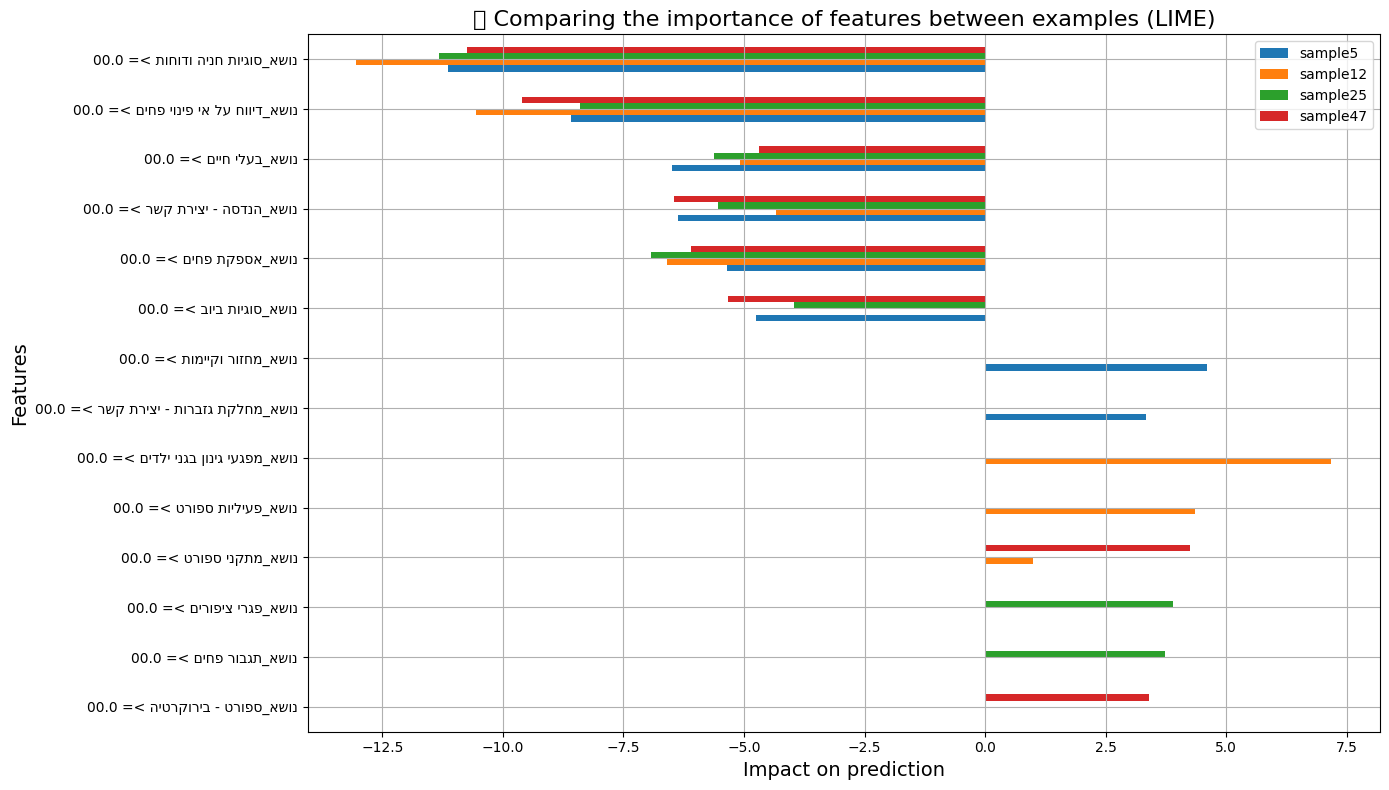

In [27]:
# 🧠 Create LIME Explainer with real feature names
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_sample,
    mode='regression',
    feature_names=scaler_cols[:X_sample.shape[1]],
    discretize_continuous=True
)

# 🧪 Select examples and explain
examples_to_explain = [5, 12, 25, 47]
num_features_show = 8

importance_df = pd.DataFrame()

for idx in examples_to_explain:
    exp = explainer.explain_instance(
        data_row=X_sample[idx],
        predict_fn=predict_fn,
        num_features=num_features_show
    )
    d = dict(exp.as_list())
    temp = pd.DataFrame.from_dict(d, orient='index', columns=[f'sample{idx}'])
    importance_df = pd.concat([importance_df, temp], axis=1)

# 🧼 Clean feature names
importance_df = importance_df.fillna(0)

# Flip Hebrew words for readability
def reverse_if_hebrew(s):
    heb_chars = set("אבגדהוזחטיכלמנסעפצקרשת")
    return reverse_hebrew(s) if any(c in s for c in heb_chars) else s

importance_df.index = importance_df.index.map(reverse_if_hebrew)

# Sort for better readability
importance_df = importance_df.iloc[::-1]

# 📊 Plot
plt.figure(figsize=(14, 8))
importance_df.plot(kind='barh', figsize=(14,8))
plt.title('🔍 Comparing the importance of features between examples (LIME)', fontsize=16)
plt.xlabel('Impact on prediction', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



🎯 דוגמה 5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📈 חיזוי מקורי: 2.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ נמצא Counterfactual אחרי 1 צעדים


,Original,Counterfactual,Δ (%)
שנה_2019,1.000000,1.000000,0.000000
שנה_2020,0.000000,0.099560,9.956041
שנה_2021,0.000000,0.021338,2.133803
שנה_2022,0.000000,0.000000,0.000000
שנה_2023,0.000000,0.052987,5.298731
...,...,...,...
נושא_תשתיות ומבני ציבורי - יצירת קשר,0.000000,0.037627,3.762655
חג,0.000000,0.000000,0.000000
Rain,0.037037,0.000000,-3.703704
calls_last_3,0.052174,0.100411,4.823685


<ipython-input-28-c53aba3d858e>:76: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


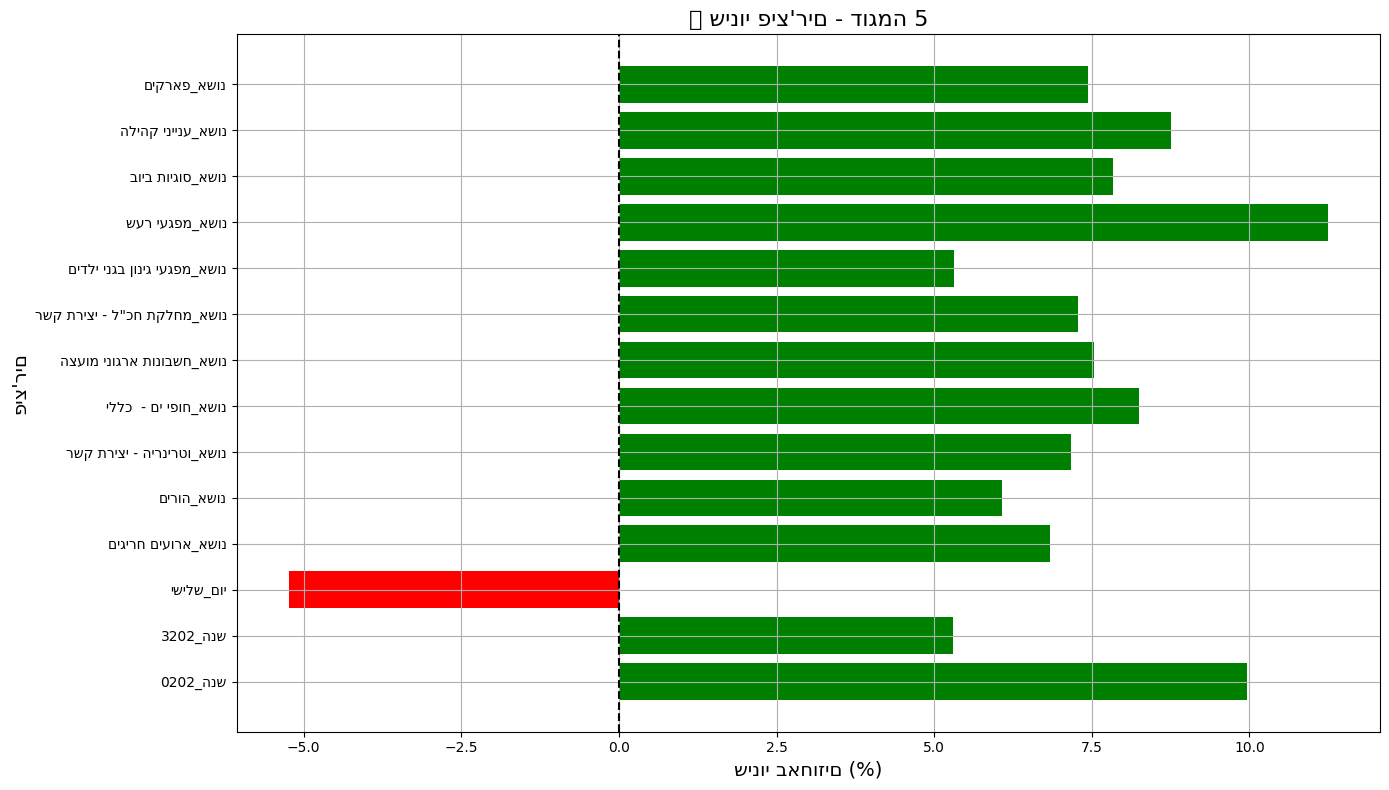

📉 חיזוי אחרי שינוי: 1.56

🎯 דוגמה 12:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📈 חיזוי מקורי: 3.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
✅ נמצא Counterfactual אחרי 1 צעדים


,Original,Counterfactual,Δ (%)
שנה_2019,0.000000,0.000000,0.000000
שנה_2020,0.000000,0.000000,0.000000
שנה_2021,0.000000,0.016125,1.612525
שנה_2022,0.000000,0.000000,0.000000
שנה_2023,0.000000,0.000000,0.000000
...,...,...,...
נושא_תשתיות ומבני ציבורי - יצירת קשר,0.000000,0.000000,0.000000
חג,0.000000,0.000000,0.000000
Rain,0.000000,0.000000,0.000000
calls_last_3,0.034783,0.000000,-3.478261


<ipython-input-28-c53aba3d858e>:76: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


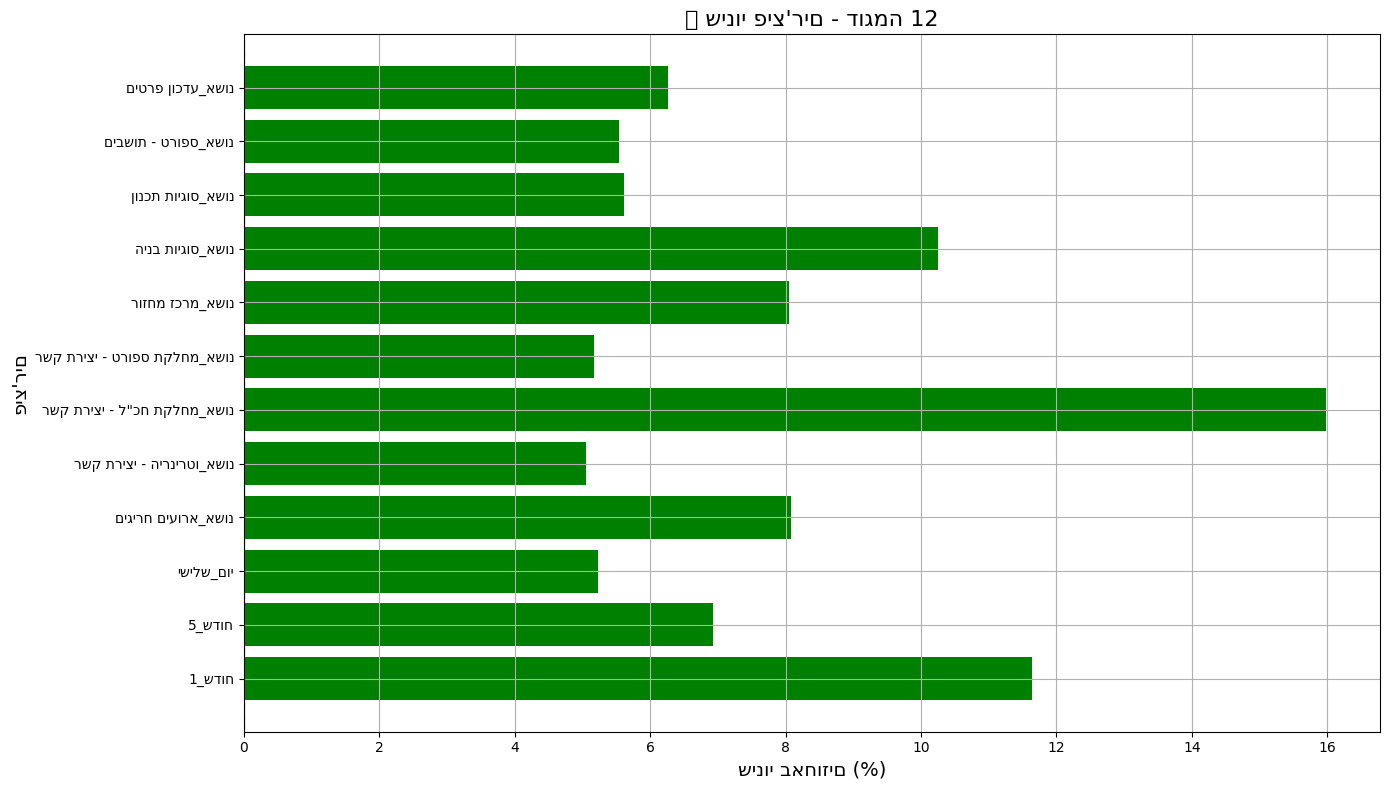

📉 חיזוי אחרי שינוי: 1.73

🎯 דוגמה 25:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📈 חיזוי מקורי: 3.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
✅ נמצא Counterfactual אחרי 1 צעדים


,Original,Counterfactual,Δ (%)
שנה_2019,0.000000,0.046320,4.632035
שנה_2020,0.000000,0.000258,0.025802
שנה_2021,0.000000,0.053196,5.319623
שנה_2022,1.000000,1.000000,0.000000
שנה_2023,0.000000,0.000000,0.000000
...,...,...,...
נושא_תשתיות ומבני ציבורי - יצירת קשר,0.000000,0.000000,0.000000
חג,0.000000,0.043268,4.326780
Rain,0.000000,0.000041,0.004105
calls_last_3,0.278261,0.345221,6.696031


<ipython-input-28-c53aba3d858e>:76: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


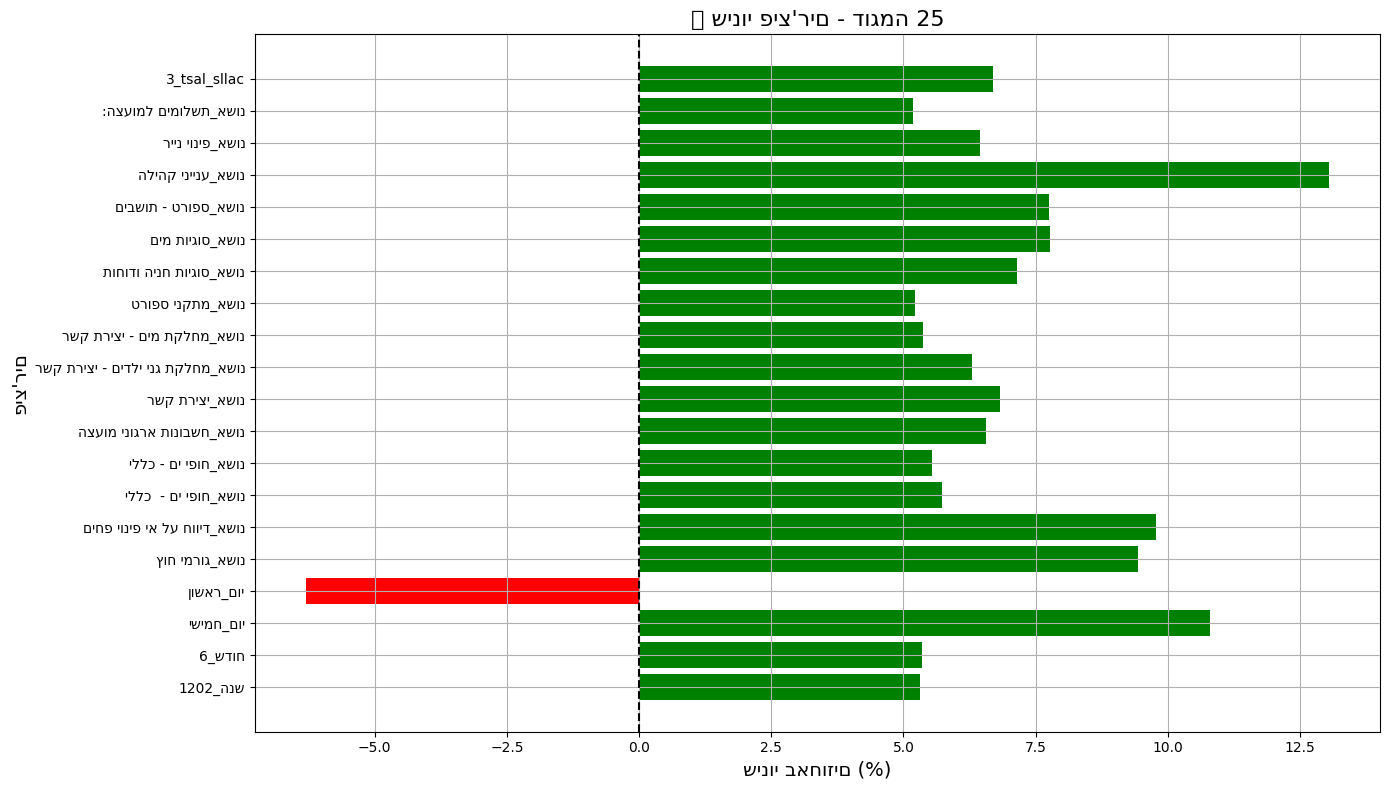

📉 חיזוי אחרי שינוי: 1.64

🎯 דוגמה 47:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📈 חיזוי מקורי: 1.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
✅ נמצא Counterfactual אחרי 1 צעדים


,Original,Counterfactual,Δ (%)
שנה_2019,1.000000,1.000000,0.000000
שנה_2020,0.000000,0.000000,0.000000
שנה_2021,0.000000,0.077603,7.760329
שנה_2022,0.000000,0.018349,1.834863
שנה_2023,0.000000,0.000000,0.000000
...,...,...,...
נושא_תשתיות ומבני ציבורי - יצירת קשר,0.000000,0.153735,15.373494
חג,0.000000,0.034638,3.463804
Rain,0.000000,0.014418,1.441771
calls_last_3,0.095652,0.139031,4.337880


<ipython-input-28-c53aba3d858e>:76: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


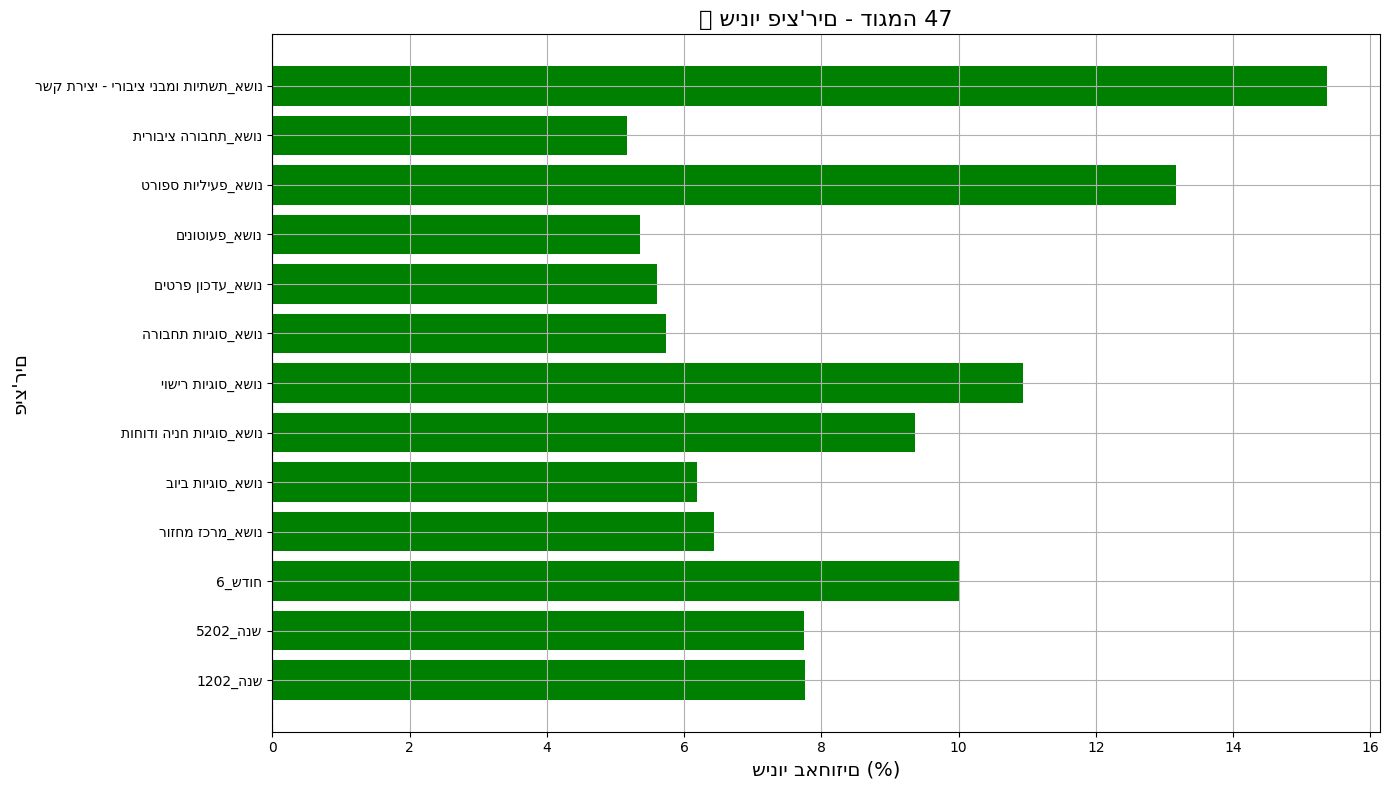

📉 חיזוי אחרי שינוי: 1.37


In [28]:
# 📦 COUNTERFACTUAL SCRIPT — בלי פונקציה, רץ ישירות

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# פונקציה להפוך עברית
def reverse_hebrew(text):
    return text[::-1]

# הכנה
X_sample = X_test[:,0,:]
predict_fn = lambda x: model.predict(x.reshape((-1,1,X_sample.shape[1]))).flatten()
feature_names = list(scaler.feature_names_in_)[:model.input_shape[-1]]

# דוגמאות לבחינה
examples_to_explain = [5, 12, 25, 47]

# פרמטרים
threshold_change = 5        # כמה אחוז שינוי נחשב משמעותי
change_goal_ratio = 0.9     # יעד – להוריד 10% לפחות מהחיזוי
max_steps = 200             # עד 200 ניסיונות

# ריצה על הדוגמאות
for idx in examples_to_explain:
    print(f"\n🎯 דוגמה {idx}:")

    x_orig = X_sample[idx].reshape(1, -1)
    pred_orig = predict_fn(x_orig)[0]
    print(f"📈 חיזוי מקורי: {pred_orig:.2f}")

    x_cf = x_orig.copy()
    success = False

    for step in range(max_steps):
        delta = np.random.normal(loc=0, scale=0.05, size=x_cf.shape)
        x_candidate = np.clip(x_cf + delta, 0, 1)
        pred_candidate = predict_fn(x_candidate)[0]

        if pred_candidate < change_goal_ratio * pred_orig:
            success = True
            print(f"✅ נמצא Counterfactual אחרי {step+1} צעדים")
            break

    if not success:
        print(f"⚠️ לא נמצא Counterfactual אחרי {max_steps} צעדים")
        continue

    # בניית טבלת השוואה
    compare_cf = pd.DataFrame({
        'Original': x_orig.flatten(),
        'Counterfactual': x_candidate.flatten()
    }, index=feature_names)
    compare_cf['Δ (%)'] = 100 * (compare_cf['Counterfactual'] - compare_cf['Original'])

    # הצגת טבלה
    display(compare_cf)

    # הצגת גרף
    changed_features = compare_cf[np.abs(compare_cf['Δ (%)']) > threshold_change]

    if changed_features.empty:
        print("⚠️ אין פיצ'רים שהשתנו ביותר מ-5%")
    else:
        plt.figure(figsize=(14,8))
        y_pos = np.arange(len(changed_features))
        bar_colors = ['green' if diff > 0 else 'red' for diff in changed_features['Δ (%)']]

        plt.barh(y_pos, changed_features['Δ (%)'], color=bar_colors)
        plt.yticks(y_pos, changed_features.index.map(reverse_hebrew))  # היפוך עברית
        plt.axvline(x=0, color='black', linestyle='--')
        plt.title(f'🚀 שינוי פיצ\'רים - דוגמה {idx}', fontsize=16)
        plt.xlabel('שינוי באחוזים (%)', fontsize=14)
        plt.ylabel('פיצ\'רים', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print(f"📉 חיזוי אחרי שינוי: {pred_candidate:.2f}")
